In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns
%matplotlib inline

In [8]:
import seaborn as sns
sns.set_style("whitegrid")

In [76]:
%config InlineBackend.figure_format = 'svg'

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [163]:
df = pd.read_csv('clean_turnstile_data FINAL.csv')

/Users/brenner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Fix 'EXITS' column name (it has many spaces at the end of it)

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637417 entries, 0 to 637416
Data columns (total 16 columns):
Unnamed: 0     637417 non-null int64
C/A            637417 non-null object
UNIT           637417 non-null object
SCP            637417 non-null object
STATION        637417 non-null object
LINENAME       637417 non-null object
DIVISION       637417 non-null object
DATE           637417 non-null object
TIME           637417 non-null object
DESC           637417 non-null object
ENTRIES        637417 non-null int64
EXITS          637417 non-null int64
DATETIME       637417 non-null object
STATION_KEY    637417 non-null object
ENTRY_DIFFS    637417 non-null float64
EXIT_DIFFS     637417 non-null float64
dtypes: float64(2), int64(3), object(11)
memory usage: 77.8+ MB


In [175]:
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']

In [5]:
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637417 entries, 0 to 637416
Data columns (total 17 columns):
Unnamed: 0     637417 non-null int64
C/A            637417 non-null object
UNIT           637417 non-null object
SCP            637417 non-null object
STATION        637417 non-null object
LINENAME       637417 non-null object
DIVISION       637417 non-null object
DATE           637417 non-null object
TIME           637417 non-null object
DESC           637417 non-null object
ENTRIES        637417 non-null int64
EXITS          637417 non-null int64
DATETIME       637417 non-null object
STATION_KEY    637417 non-null object
ENTRY_DIFFS    637417 non-null float64
EXIT_DIFFS     637417 non-null float64
TOTAL          637417 non-null float64
dtypes: float64(3), int64(3), object(11)
memory usage: 82.7+ MB


In [ ]:
sns.pairplot(df)

In [4]:
# old_exit_name = df.columns[-1]
df.rename(columns={df.columns[-1]: 'EXITS'}, inplace = True)

In [5]:
backup_df = df.copy()

In [167]:
# this is slow...FYI
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df['STATION_KEY'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['STATION']

In [ ]:
# cols_to_drop = ['C/A','UNIT','STATION']
# cols_to_drop = ['C/A','UNIT']
# df.drop(cols_to_drop, axis=1, inplace=True)

Sort, Group by Station Key, then compute difference between 'ENTRIES'

In [7]:
# need this
df.sort_values(['STATION_KEY', 'SCP', 'DATETIME'], inplace=True)

In [ ]:
df['ENTRY_DIFFS'] = df.groupby(['STATION_KEY','SCP'])['ENTRIES'].diff(periods=-1)*-1

In [10]:
df['EXIT_DIFFS'] = df.groupby(['STATION_KEY','SCP'])['EXITS'].diff(periods=-1)*-1

The majority of 'ENTRY_DIFFS' values are reasonable, but there are still some large negative and positive values still. For now, exclude them from our analysis. (There shouldn't, in fact, be any negative values.)

In [11]:
# 200,000 entries per day is a reasonable cut-off
clean_df = df[(df['ENTRY_DIFFS'] < 2E5) 
              & (df['ENTRY_DIFFS'] > 0) 
              & (df['EXIT_DIFFS'] < 2E5)
              & (df['EXIT_DIFFS'] > 0)]

In [7]:
plt.hist(clean_df['EXIT_DIFFS'].dropna())

NameError: name 'clean_df' is not defined

(array([  1.20340000e+05,   2.51650000e+04,   7.43600000e+03,
          2.26400000e+03,   8.29000000e+02,   2.89000000e+02,
          8.10000000e+01,   5.10000000e+01,   1.50000000e+01,
          3.00000000e+00]),
 array([  1.00000000e+00,   3.28800000e+02,   6.56600000e+02,
          9.84400000e+02,   1.31220000e+03,   1.64000000e+03,
          1.96780000e+03,   2.29560000e+03,   2.62340000e+03,
          2.95120000e+03,   3.27900000e+03]),
 <a list of 10 Patch objects>)

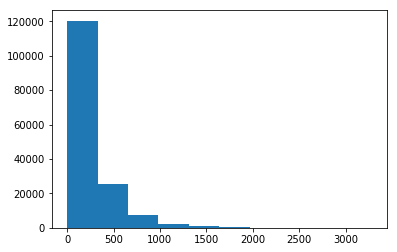

In [13]:
plt.hist(clean_df['ENTRY_DIFFS'].dropna())

(array([  1.20340000e+05,   2.51650000e+04,   7.43600000e+03,
          2.26400000e+03,   8.29000000e+02,   2.89000000e+02,
          8.10000000e+01,   5.10000000e+01,   1.50000000e+01,
          3.00000000e+00]),
 array([  1.00000000e+00,   3.28800000e+02,   6.56600000e+02,
          9.84400000e+02,   1.31220000e+03,   1.64000000e+03,
          1.96780000e+03,   2.29560000e+03,   2.62340000e+03,
          2.95120000e+03,   3.27900000e+03]),
 <a list of 10 Patch objects>)

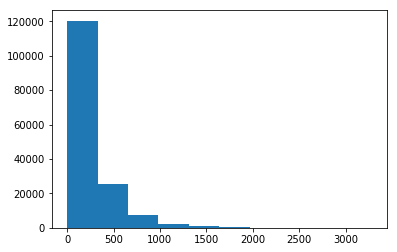

In [13]:
plt.hist(clean_df['ENTRY_DIFFS'].dropna())

In [18]:
grp1 = df.groupby(['STATION_KEY', 'DATE'])['ENTRY_DIFFS','EXIT_DIFFS'].sum().reset_index()

In [19]:
grp1.head()

,STATION_KEY,DATE,ENTRY_DIFFS,EXIT_DIFFS
0,A002 R051 59 ST,2018-05-19,6838.0,3981.0
1,A002 R051 59 ST,2018-05-20,5712.0,3452.0
2,A002 R051 59 ST,2018-05-21,13167.0,8141.0
3,A002 R051 59 ST,2018-05-22,13706.0,8690.0
4,A002 R051 59 ST,2018-05-23,14233.0,8919.0


Take the highest-volume stations and look at them more closely

In [20]:
highest_vol = clean_df.sort_values('ENTRY_DIFFS').tail(100)['STATION_KEY'].unique()

In [21]:
x_labels = calendar.day_name[5:] + calendar.day_name[:5]

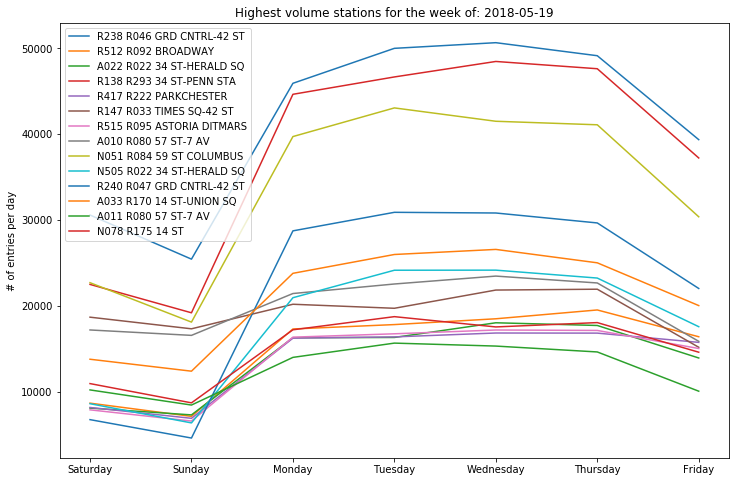

In [22]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION_KEY'] == s]
    xs = dum_df['DATE']
    week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['ENTRY_DIFFS'], label=s)
    xticklocs = ax.get_xticks()
    plt.xticks(xticklocs, x_labels)
    plt.legend()
    plt.ylabel('# of entries per day')
    plt.title('Highest volume stations for the week of: ' + str(week_start));

**Next steps:** 
- determine what we want our "weekday vs weekend" cut-off to be. 
- plot a heatmap of a few of these stations (GRD CENTRAL, ASTORIA DITMARS, e.g.)

In [33]:
def get_station_data(s):
    '''Given station key ,
    returns all entries from cleaned data frame for this station '''
    #d = dt.datetime(d_tuple)
    return clean_df[clean_df['STATION_KEY'] == s]

In [ ]:
def station_datetime(s, d):
    '''Given station key and date,
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    #d = dt.datetime(d_tuple)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]

In [ ]:
def station_dayints(s, year, month, day):
    '''Given station key and date,
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]

In [23]:
import seaborn as sns

In [33]:
def get_station_data(s):
    '''Given station key ,
    returns all entries from cleaned data frame for this station '''
    #d = dt.datetime(d_tuple)
    return df[df['STATION_KEY'] == s]

In [34]:
get_station_data('A002 R051 59 ST')

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,20:00:00,REGULAR,6626018,2245520,2018-05-19 20:00:00,A002 R051 59 ST,112.0,17.0,129.0
6,6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-20,00:00:00,REGULAR,6626130,2245537,2018-05-20 00:00:00,A002 R051 59 ST,19.0,8.0,27.0
7,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-20,04:00:00,REGULAR,6626149,2245545,2018-05-20 04:00:00,A002 R051 59 ST,11.0,19.0,30.0
8,8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-20,08:00:00,REGULAR,6626160,2245564,2018-05-20 08:00:00,A002 R051 59 ST,63.0,56.0,119.0
9,9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-20,12:00:00,REGULAR,6626223,2245620,2018-05-20 12:00:00,A002 R051 59 ST,163.0,52.0,215.0


In [39]:
def heatmap_data_old(s, year, month, day):
    '''Given station key and date,c
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)][['DATETIME','ENTRY_DIFFS']]

In [42]:
def heatmap_data(s, year, month, day):
    '''Given station key and date,c
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    dum_df = clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]
    return dum_df.groupby('DATETIME')['ENTRY_DIFFS'].sum()

In [24]:
gc_key = highest_vol[0]

In [34]:
gc_data = get_station_data(gc_key)

In [35]:
gc_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS
152751,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,00:00:00,REGULAR,678,7417,2018-05-19 00:00:00,R238 R046 GRD CNTRL-42 ST,13.0,62.0
152752,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,04:00:00,REGULAR,691,7479,2018-05-19 04:00:00,R238 R046 GRD CNTRL-42 ST,9.0,121.0
152753,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,08:00:00,REGULAR,700,7600,2018-05-19 08:00:00,R238 R046 GRD CNTRL-42 ST,60.0,513.0
152754,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,12:00:00,REGULAR,760,8113,2018-05-19 12:00:00,R238 R046 GRD CNTRL-42 ST,108.0,747.0
152755,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,16:00:00,REGULAR,868,8860,2018-05-19 16:00:00,R238 R046 GRD CNTRL-42 ST,104.0,567.0


In [43]:
heatmap_data(gc_key, 2018, 5, 19)

DATETIME
2018-05-19 00:00:00    1778.0
2018-05-19 04:00:00    1132.0
2018-05-19 08:00:00    5631.0
2018-05-19 12:00:00    8925.0
2018-05-19 16:00:00    8736.0
2018-05-19 20:00:00    4367.0
Name: ENTRY_DIFFS, dtype: float64

In [36]:
hm_data = gc_data.groupby('DATETIME')['ENTRY_DIFFS'].sum()

DATETIME
2018-05-19 00:00:00     1778.0
2018-05-19 04:00:00     1132.0
2018-05-19 08:00:00     5631.0
2018-05-19 12:00:00     8925.0
2018-05-19 16:00:00     8736.0
2018-05-19 20:00:00     4367.0
2018-05-20 00:00:00     1388.0
2018-05-20 04:00:00      604.0
2018-05-20 08:00:00     5064.0
2018-05-20 12:00:00     6829.0
2018-05-20 16:00:00     7284.0
2018-05-20 20:00:00     4263.0
2018-05-21 00:00:00      626.0
2018-05-21 04:00:00     4326.0
2018-05-21 08:00:00    11975.0
2018-05-21 12:00:00     8546.0
2018-05-21 16:00:00    13920.0
2018-05-21 20:00:00     6521.0
2018-05-22 00:00:00      687.0
2018-05-22 04:00:00     4564.0
2018-05-22 08:00:00    11276.0
2018-05-22 12:00:00    10331.0
2018-05-22 16:00:00    16474.0
2018-05-22 20:00:00     6647.0
2018-05-23 00:00:00     1303.0
2018-05-23 04:00:00     4446.0
2018-05-23 08:00:00    11503.0
2018-05-23 12:00:00     9947.0
2018-05-23 16:00:00    15888.0
2018-05-23 20:00:00     7557.0
2018-05-24 00:00:00     1428.0
2018-05-24 04:00:00     4208.0

In [48]:
gc_hmdata = [heatmap_data(gc_key, 2018, 5, d) for d in range(19,26)]
# gc_hmdata

In [49]:
gc_hmdata

[DATETIME
 2018-05-19 00:00:00    1778.0
 2018-05-19 04:00:00    1132.0
 2018-05-19 08:00:00    5631.0
 2018-05-19 12:00:00    8925.0
 2018-05-19 16:00:00    8736.0
 2018-05-19 20:00:00    4367.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-20 00:00:00    1388.0
 2018-05-20 04:00:00     604.0
 2018-05-20 08:00:00    5064.0
 2018-05-20 12:00:00    6829.0
 2018-05-20 16:00:00    7284.0
 2018-05-20 20:00:00    4263.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-21 00:00:00      626.0
 2018-05-21 04:00:00     4326.0
 2018-05-21 08:00:00    11975.0
 2018-05-21 12:00:00     8546.0
 2018-05-21 16:00:00    13920.0
 2018-05-21 20:00:00     6521.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-22 00:00:00      687.0
 2018-05-22 04:00:00     4564.0
 2018-05-22 08:00:00    11276.0
 2018-05-22 12:00:00    10331.0
 2018-05-22 16:00:00    16474.0
 2018-05-22 20:00:00     6647.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-23 00:00:00     1303.0
 2018-05-23 04:00:00  

In [54]:
len(gc_hmdata[-1]

DATETIME
2018-05-25 00:00:00     1534.0
2018-05-25 04:00:00     3401.0
2018-05-25 08:00:00     9524.0
2018-05-25 12:00:00    11808.0
2018-05-25 16:00:00    13085.0
Name: ENTRY_DIFFS, dtype: float64

In [53]:
gc_hmdata[-1].append(dt.datetime(2018,5,25,20,0,0),5000)

TypeError: cannot concatenate object of type "<class 'datetime.datetime'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

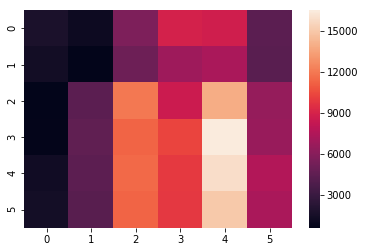

In [51]:
sns.heatmap(gc_hmdata[:-1])

In [47]:
for x in gc_hmdata:
    print(len(x))

6
6
6
6
6
6
5
0


In [30]:
gc_hmdata[:20]

[                  DATETIME  ENTRY_DIFFS
 152751 2018-05-19 00:00:00         13.0
 152752 2018-05-19 04:00:00          9.0
 152753 2018-05-19 08:00:00         60.0
 152754 2018-05-19 12:00:00        108.0
 152755 2018-05-19 16:00:00        104.0
 152756 2018-05-19 20:00:00         24.0
 152793 2018-05-19 00:00:00         21.0
 152794 2018-05-19 04:00:00         12.0
 152795 2018-05-19 08:00:00        143.0
 152796 2018-05-19 12:00:00        185.0
 152797 2018-05-19 16:00:00        131.0
 152798 2018-05-19 20:00:00         57.0
 152835 2018-05-19 00:00:00         27.0
 152836 2018-05-19 04:00:00         10.0
 152837 2018-05-19 08:00:00        160.0
 152838 2018-05-19 12:00:00        209.0
 152839 2018-05-19 16:00:00        161.0
 152840 2018-05-19 20:00:00         50.0
 152877 2018-05-19 00:00:00         18.0
 152878 2018-05-19 04:00:00         21.0
 152879 2018-05-19 08:00:00        138.0
 152880 2018-05-19 12:00:00        209.0
 152881 2018-05-19 16:00:00        130.0
 152882 2018-05-

In [8]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19 00:00:00,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19 00:00:00,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19 00:00:00,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19 00:00:00,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19 00:00:00,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0


/Users/brenner/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


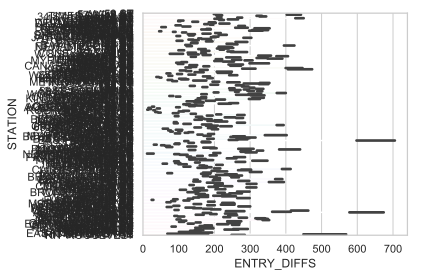

In [168]:
sns.barplot(x="ENTRY_DIFFS", y='STATION', data=df)

# plt.xlabel('Traffic', fontsize=12)
# plt.ylabel('Station', fontsize=12)
plt.tight_layout()
# plt.savefig('charts/Top20.png')
plt.show()

In [169]:
df['STATION_KEY'].value_counts().head(10)

PTH22 R540 PATH NEW WTC      5937
PTH03 R552 JOURNAL SQUARE    3215
R610 R057 ATL AV-BARCLAY     3170
PTH04 R551 GROVE STREET      3078
PTH07 R550 CITY / BUS        3004
PTH05 R543 EXCHANGE PLACE    2980
R533 R055 FLUSHING-MAIN      2679
N094 R029 WORLD TRADE CTR    2627
PTH16 R550 LACKAWANNA        2491
A046 R463 CANAL ST           2430
Name: STATION_KEY, dtype: int64

TypeError: <lambda>() missing 1 required positional argument: 'width'

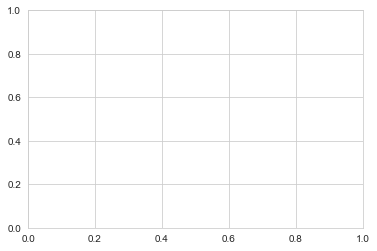

In [170]:
df.groupby(['STATION_KEY']).sum()['ENTRY_DIFFS']

STATION_KEY
A002 R051 59 ST              311764.0
A006 R079 5 AV/59 ST         281633.0
A007 R079 5 AV/59 ST         127601.0
A010 R080 57 ST-7 AV         549966.0
A011 R080 57 ST-7 AV         294455.0
A013 R081 49 ST              149273.0
A014 R081 49 ST              114677.0
A015 R081 49 ST              265058.0
A016 R081 49 ST              152652.0
A021 R032 TIMES SQ-42 ST     369391.0
A022 R022 34 ST-HERALD SQ    396990.0
A025 R023 34 ST-HERALD SQ    546447.0
A027 R082 28 ST              177897.0
A029 R082 28 ST              137327.0
A030 R083 23 ST              353708.0
A031 R083 23 ST              227419.0
A033 R170 14 ST-UNION SQ     582402.0
A034 R170 14 ST-UNION SQ     570414.0
A035 R170 14 ST-UNION SQ     220621.0
A037 R170 14 ST-UNION SQ     441735.0
A038 R085 8 ST-NYU           303150.0
A039 R085 8 ST-NYU           113761.0
A041 R086 PRINCE ST          307733.0
A042 R086 PRINCE ST          110480.0
A043 R462 CANAL ST           417215.0
A046 R463 CANAL ST           576803.0


In [35]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0


In [171]:
top = df.groupby(['STATION']).sum()

In [172]:
top.head(5)

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS
STATION,,,,,
1 AV,548431898,510718568469,273491462727,571582.0,624905.0
103 ST,1043238259,24988299198,99629869671,804844.0,543799.0
103 ST-CORONA,715928500,10927192536,11269639755,503029.0,365677.0
104 ST,328284184,2217960120,1755130074,71630.0,32287.0
110 ST,448139564,5689341368,5514536422,278100.0,232013.0


In [133]:
top

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
STATION,,,,,,
34 ST-PENN STA,5700887724,579640474869,486824909756,3944669.0,3385591.0,7330260.0
GRD CNTRL-42 ST,4004680914,151992658158,138283333593,3410773.0,2822045.0,6232818.0
34 ST-HERALD SQ,2852055453,251907592486,222368000913,2637879.0,2344496.0,4982375.0
14 ST-UNION SQ,2015613399,138969967442,46520271480,2602551.0,2294213.0,4896764.0
TIMES SQ-42 ST,3121284890,653134520189,299150620862,2509383.0,2347343.0,4856726.0
23 ST,3554259204,562246507332,451941522714,2555937.0,1810657.0,4366594.0
FULTON ST,4481975261,578594147058,406484094965,2269203.0,1860096.0,4129299.0
42 ST-PORT AUTH,2329846917,564576198075,409349290221,2211223.0,1802952.0,4014175.0
86 ST,3042541288,164227784901,88970659000,1955689.0,1701178.0,3656867.0


In [174]:
top

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS
STATION,,,,,
1 AV,548431898,510718568469,273491462727,571582.0,624905.0
103 ST,1043238259,24988299198,99629869671,804844.0,543799.0
103 ST-CORONA,715928500,10927192536,11269639755,503029.0,365677.0
104 ST,328284184,2217960120,1755130074,71630.0,32287.0
110 ST,448139564,5689341368,5514536422,278100.0,232013.0
111 ST,916930040,11912071529,8051711226,413775.0,193698.0
116 ST,1427955842,66511886333,67220307327,821177.0,443536.0
116 ST-COLUMBIA,428200621,197973032433,42468822333,282018.0,152759.0
121 ST,246276154,1390879191,1131600628,30054.0,12865.0


In [188]:
top = df.groupby(['STATION']).sum()
top = top.sort_values(['TOTAL'], ascending=False)

In [189]:
top

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
STATION,,,,,,,
34 ST-PENN STA,5700887724,579640474869,486824909756,3944669.0,3385591.0,7330260.0,44792
GRD CNTRL-42 ST,4004680914,151992658158,138283333593,3410773.0,2822045.0,6232818.0,26066
34 ST-HERALD SQ,2852055453,251907592486,222368000913,2637879.0,2344496.0,4982375.0,23461
14 ST-UNION SQ,2015613399,138969967442,46520271480,2602551.0,2294213.0,4896764.0,17772
TIMES SQ-42 ST,3121284890,653134520189,299150620862,2509383.0,2347343.0,4856726.0,23121
23 ST,3554259204,562246507332,451941522714,2555937.0,1810657.0,4366594.0,27415
FULTON ST,4481975261,578594147058,406484094965,2269203.0,1860096.0,4129299.0,34178
42 ST-PORT AUTH,2329846917,564576198075,409349290221,2211223.0,1802952.0,4014175.0,20276
86 ST,3042541288,164227784901,88970659000,1955689.0,1701178.0,3656867.0,22663


In [187]:
df.groupby(['STATION']).sum()

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
STATION,,,,,,,
1 AV,548431898,510718568469,273491462727,571582.0,624905.0,1196487.0,5025
103 ST,1043238259,24988299198,99629869671,804844.0,543799.0,1348643.0,7349
103 ST-CORONA,715928500,10927192536,11269639755,503029.0,365677.0,868706.0,4525
104 ST,328284184,2217960120,1755130074,71630.0,32287.0,103917.0,2805
110 ST,448139564,5689341368,5514536422,278100.0,232013.0,510113.0,2948
111 ST,916930040,11912071529,8051711226,413775.0,193698.0,607473.0,6968
116 ST,1427955842,66511886333,67220307327,821177.0,443536.0,1264713.0,9769
116 ST-COLUMBIA,428200621,197973032433,42468822333,282018.0,152759.0,434777.0,2965
121 ST,246276154,1390879191,1131600628,30054.0,12865.0,42919.0,2168


In [184]:
top

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
STATION,,,,,,,
34 ST-PENN STA,5700887724,579640474869,486824909756,3944669.0,3385591.0,7330260.0,44792
GRD CNTRL-42 ST,4004680914,151992658158,138283333593,3410773.0,2822045.0,6232818.0,26066
34 ST-HERALD SQ,2852055453,251907592486,222368000913,2637879.0,2344496.0,4982375.0,23461
14 ST-UNION SQ,2015613399,138969967442,46520271480,2602551.0,2294213.0,4896764.0,17772
TIMES SQ-42 ST,3121284890,653134520189,299150620862,2509383.0,2347343.0,4856726.0,23121
23 ST,3554259204,562246507332,451941522714,2555937.0,1810657.0,4366594.0,27415
FULTON ST,4481975261,578594147058,406484094965,2269203.0,1860096.0,4129299.0,34178
42 ST-PORT AUTH,2329846917,564576198075,409349290221,2211223.0,1802952.0,4014175.0,20276
86 ST,3042541288,164227784901,88970659000,1955689.0,1701178.0,3656867.0,22663


In [128]:
x = top['TOTAL'].head(10).index
y = top['TOTAL'].head(10).values

<BarContainer object of 10 artists>

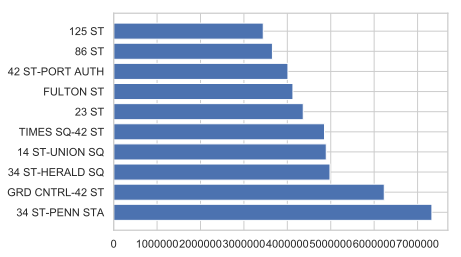

In [129]:
plt.barh(x,y)

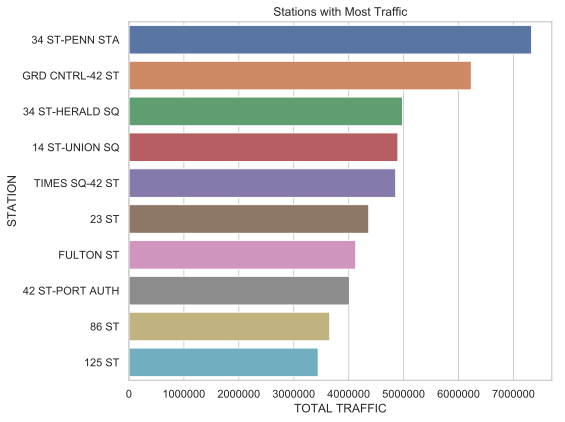

In [132]:
f, ax = plt.subplots(figsize=(8,6))
plt.title('Stations with Most Traffic')
plt.xlabel('TOTAL TRAFFIC')
plt.ylabel('Stations')
sns.barplot(x=y, y=x, data=top)
plt.tight_layout()

f.savefig('output4.svg')

In [131]:
sns.set(style='whitegrid')

In [108]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637417 entries, 0 to 637416
Data columns (total 17 columns):
Unnamed: 0     637417 non-null int64
C/A            637417 non-null object
UNIT           637417 non-null object
SCP            637417 non-null object
STATION        637417 non-null object
LINENAME       637417 non-null object
DIVISION       637417 non-null object
DATE           637417 non-null datetime64[ns]
TIME           637417 non-null object
DESC           637417 non-null object
ENTRIES        637417 non-null int64
EXITS          637417 non-null int64
DATETIME       637417 non-null datetime64[ns]
STATION_KEY    637417 non-null object
ENTRY_DIFFS    637417 non-null float64
EXIT_DIFFS     637417 non-null float64
TOTAL          637417 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(9)
memory usage: 82.7+ MB


In [135]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0


In [178]:
df['DAY_OF_WEEK'] = df['DATETIME'].dt.dayofweek

In [179]:
top2 = df.groupby(['STATION', 'DATE']).sum()


In [182]:
top.head(3)

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL
STATION,,,,,,
34 ST-PENN STA,5700887724,579640474869,486824909756,3944669.0,3385591.0,7330260.0
GRD CNTRL-42 ST,4004680914,151992658158,138283333593,3410773.0,2822045.0,6232818.0
34 ST-HERALD SQ,2852055453,251907592486,222368000913,2637879.0,2344496.0,4982375.0


In [181]:
top2 = df.groupby(['DATE']).sum()
    

top2[top2['STATION']=='TIMES SQ-42 ST']

KeyError: 'STATION'

In [144]:
top2 = top2.sort_values(['TOTAL'], ascending=False)

,,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
DATE,STATION,,,,,,,
2018-06-13,34 ST-PENN STA,367478242,20825848575,17545944854,179230.0,151539.0,330769.0,1086
2018-06-14,34 ST-PENN STA,367000144,21032649756,17536073060,177699.0,150981.0,328680.0,1626
2018-05-23,34 ST-PENN STA,45958846,20860069033,17507255728,177546.0,150489.0,328035.0,1070
2018-06-07,34 ST-PENN STA,266740074,19625271539,16481175511,175863.0,149334.0,325197.0,1662
2018-05-22,34 ST-PENN STA,46272013,20869596662,17509661581,174082.0,149064.0,323146.0,538
2018-05-24,34 ST-PENN STA,46093993,20670755753,17518523077,174235.0,148763.0,322998.0,1608
2018-05-31,34 ST-PENN STA,154464341,19470040195,16420886073,174144.0,147695.0,321839.0,1635
2018-06-12,34 ST-PENN STA,368997099,21139838107,17543265253,174555.0,146552.0,321107.0,545
2018-06-05,34 ST-PENN STA,256150034,20782491344,17512274176,172726.0,146203.0,318929.0,534


In [230]:
top2.head()

Unnamed: 0      ENTRIES       EXITS  ENTRY_DIFFS  \
STATION DATE                                                           
1 AV    2018-05-19     1834230  18222641195  9750032574      19241.0   
        2018-05-20     1834590  18222750635  9750157007      15258.0   
        2018-05-21     1834950  18222852597  9750276494      21686.0   
        2018-05-22     1835310  18222984426  9750419336      22712.0   
        2018-05-23     1835670  18223121120  9750571611      23654.0   

                    EXIT_DIFFS    TOTAL  DAY_OF_WEEK  
STATION DATE                                          
1 AV    2018-05-19     21979.0  41220.0          300  
        2018-05-20     16773.0  32031.0          360  
        2018-05-21     23663.0  45349.0            0  
        2018-05-22     25362.0  48074.0           60  
        2018-05-23     25091.0  48745.0          120

In [156]:
data_date = df.groupby(["DATE"]).sum() # sort by station and date
data_date.reset_index(inplace=True) # remove Station and Date columns from Index
# data_date['DATE'] = pd.to_datetime(data_date['Date']) # change Date dtype to datetime
data_date.head()

,DATE,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
0,2018-05-19,2089298534,582265292653,420951542894,3029871.0,2419537.0,5449408.0,108115
1,2018-05-20,2062097765,579686103083,420585680596,2577729.0,2058936.0,4636665.0,128250
2,2018-05-21,2289757547,625737137120,458635291588,5699287.0,4263290.0,9962577.0,0
3,2018-05-22,2299313846,630569784400,460760241201,5925016.0,4430520.0,10355536.0,23403
4,2018-05-23,2304987498,637350288411,465423421519,6073650.0,4545626.0,10619276.0,46890


In [161]:
df['DATETIME'].describe()

count                  637417
unique                  38175
top       2018-05-31 16:00:00
freq                     2141
Name: DATETIME, dtype: object

In [193]:
new = df[df['STATION'] == '34 ST-PENN STA']

In [195]:
new.groupby(['DATE']).sum()['TOTAL']

DATE
2018-05-19    166123.0
2018-05-20    138162.0
2018-05-21    299543.0
2018-05-22    323146.0
2018-05-23    328035.0
2018-05-24    322998.0
2018-05-25    290709.0
2018-05-26    155536.0
2018-05-27    124985.0
2018-05-28    143750.0
2018-05-29    315311.0
2018-05-30    318427.0
2018-05-31    321839.0
2018-06-01    318584.0
2018-06-02    164494.0
2018-06-03    144518.0
2018-06-04    309938.0
2018-06-05    318929.0
2018-06-06    318059.0
2018-06-07    325197.0
2018-06-08    310347.0
2018-06-09    165112.0
2018-06-10    137114.0
2018-06-11    307482.0
2018-06-12    321107.0
2018-06-13    330769.0
2018-06-14    328680.0
2018-06-15    281366.0
Name: TOTAL, dtype: float64

In [207]:
a = new.groupby(['DATE']).sum()['TOTAL'].index
b = new.groupby(['DATE']).sum()['TOTAL'].values

In [215]:
a = np.array(a)

In [220]:
len(a)

28

In [221]:
len(b)

28

In [214]:
type(b)

numpy.ndarray

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabels'

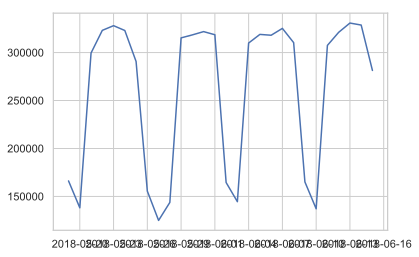

In [227]:
plt.plot(a,b)
plt.xlabels(rotate=45)

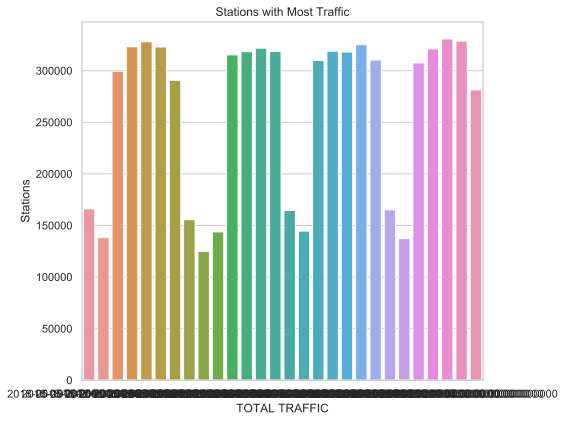

In [223]:
f, ax = plt.subplots(figsize=(8,6))
plt.title('Stations with Most Traffic')
plt.xlabel('TOTAL TRAFFIC')
plt.ylabel('Stations')
sns.barplot(y=b, x=a, data=new)
plt.tight_layout()

f.savefig('station2.svg')

In [ ]:
df['COMMUTER'] = df.apply()

In [229]:
new.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
167156,50626,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2018-05-19,00:00:00,REGULAR,2022759,2044139,2018-05-19 00:00:00,N067 R012 34 ST-PENN STA,7.0,14.0,21.0,5
167157,50627,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2018-05-19,04:00:00,REGULAR,2022766,2044153,2018-05-19 04:00:00,N067 R012 34 ST-PENN STA,11.0,94.0,105.0,5
167158,50628,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2018-05-19,08:00:00,REGULAR,2022777,2044247,2018-05-19 08:00:00,N067 R012 34 ST-PENN STA,54.0,177.0,231.0,5
167159,50629,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2018-05-19,12:00:00,REGULAR,2022831,2044424,2018-05-19 12:00:00,N067 R012 34 ST-PENN STA,65.0,197.0,262.0,5
167160,50630,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2018-05-19,16:00:00,REGULAR,2022896,2044621,2018-05-19 16:00:00,N067 R012 34 ST-PENN STA,64.0,188.0,252.0,5


<bound method NDFrame.head of                       Unnamed: 0      ENTRIES        EXITS  ENTRY_DIFFS  \
STATION   DATE                                                            
1 AV      2018-05-19     1834230  18222641195   9750032574      19241.0   
          2018-05-20     1834590  18222750635   9750157007      15258.0   
          2018-05-21     1834950  18222852597   9750276494      21686.0   
          2018-05-22     1835310  18222984426   9750419336      22712.0   
          2018-05-23     1835670  18223121120   9750571611      23654.0   
          2018-05-24     1836030  18223262523   9750722852      23388.0   
          2018-05-25     1805807  18217402857   9750370128      23479.0   
          2018-05-26    13700670  18223532417   9751008902      16280.0   
          2018-05-27    13701030  18223623023   9751112606      12713.0   
          2018-05-28    13701390  18223698202   9751199614      12175.0   
          2018-05-29    13473411  18217784718   9750806567      21606.

In [238]:
df['WEEKDAY'] = df['DAY_OF_WEEK'].apply(weekday)

In [241]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,WEEKDAY
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0,5,0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0,5,0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0,5,0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0,5,0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0,5,0


In [240]:
df.describe()

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,WEEKDAY
count,637417.000000,6.374170e+05,6.374170e+05,637417.000000,637417.000000,637417.000000,637417.000000,637417.000000
mean,392263.928752,2.712203e+07,1.977596e+07,213.402501,161.961036,375.363538,2.951413,0.726713
std,227254.375398,1.589074e+08,1.305487e+08,264.914522,237.626597,395.353848,1.985241,0.445647
min,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,2.000000,0.000000,0.000000
25%,195237.000000,8.410810e+05,4.960020e+05,33.000000,25.000000,85.000000,1.000000,0.000000
50%,392534.000000,3.098000e+06,1.852192e+06,120.000000,78.000000,249.000000,3.000000,1.000000
75%,587925.000000,7.079300e+06,5.131469e+06,293.000000,201.000000,533.000000,5.000000,1.000000
max,788529.000000,2.115507e+09,2.037127e+09,5479.000000,5584.000000,8503.000000,6.000000,1.000000


In [236]:
def weekend(x):
    if x <= 4:
        return 1
    else:
        return 0

In [243]:
top2

Unnamed: 0      ENTRIES        EXITS  ENTRY_DIFFS  \
STATION   DATE                                                            
1 AV      2018-05-19     1834230  18222641195   9750032574      19241.0   
          2018-05-20     1834590  18222750635   9750157007      15258.0   
          2018-05-21     1834950  18222852597   9750276494      21686.0   
          2018-05-22     1835310  18222984426   9750419336      22712.0   
          2018-05-23     1835670  18223121120   9750571611      23654.0   
          2018-05-24     1836030  18223262523   9750722852      23388.0   
          2018-05-25     1805807  18217402857   9750370128      23479.0   
          2018-05-26    13700670  18223532417   9751008902      16280.0   
          2018-05-27    13701030  18223623023   9751112606      12713.0   
          2018-05-28    13701390  18223698202   9751199614      12175.0   
          2018-05-29    13473411  18217784718   9750806567      21606.0   
          2018-05-30    13702110  18223920789   9751455704      22857.0   
          2018-05-31    13702470  18224058379   9751606587      23042.0   
          2018-06-01    13702830  18224197659   9751759308      24477.0   
          2018-06-02    25507590  18224336432   9751904433      19045.0   
          2018-06-03    25507950  18224444318   9752027926      14946.0   
          2018-06-04    25508310  18224546565   9752148265      22162.0   
          2018-06-05    25508670  18224676258   9752287142      20847.0   
          2018-06-06    31885800  21713370624  11819162045      23643.0   
          2018-06-07    25509480  18224945475   9752575200      22116.0   
          2018-06-08    25509840  18225081138   9752723386      24405.0   
          2018-06-09    37315110  18225219933   9752866179      18889.0   
          2018-06-10    37315470  18225325824   9752981923      14367.0   
          2018-06-11    37315830  18225423417   9753095188      21548.0   
          2018-06-12    37316190  18225554918   9753235860      22581.0   
          2018-06-13    37316550  18225690779   9753380521      22684.0   
          2018-06-14    37316910  18225827782   9753526940      23746.0   
          2018-06-15    31097700  15188294466   8128048429      18035.0   
103 ST    2018-05-19    11564091    907976202   3589220031      19170.0   
          2018-05-20    11564631    908085377   3589294718      16356.0   
...                          ...          ...          ...          ...   
YORK ST   2018-06-14    12426669    234824310    196800634      13494.0   
          2018-06-15    10355640    195746633    164025492      10795.0   
ZEREGA AV 2018-05-19     4184940    326338397      9478722       1264.0   
          2018-05-20     4185084    326345357      9486010       1020.0   
          2018-05-21     3661881    325065122      9260733       2783.0   
          2018-05-22     4010921    325943185      9432141       2797.0   
          2018-05-23     4185516    326390746      9525749       2849.0   
          2018-05-24     4185660    326407814      9540613       2868.0   
          2018-05-25     4185804    326424379      9555851       2645.0   
          2018-05-26     8908068    326435853      9567693       1322.0   
          2018-05-27     8908212    326442876      9574870        982.0   
          2018-05-28     8537240    273169345      8388580       1045.0   
          2018-05-29     8908500    326460235      9590328       2582.0   
          2018-05-30     8908644    326475735      9605489       2564.0   
          2018-05-31     8908788    326491131      9620785       2538.0   
          2018-06-01     8908932    326506449      9635908       2621.0   
          2018-06-02    13630908    326517939      9647779       1326.0   
          2018-06-03    13631052    326525026      9654813       1024.0   
          2018-06-04    13631196    326536610      9664457       2749.0   
          2018-06-05    13631340    326553246      9679652       2800.0   
          2018-06-06    13631484    326570353  

In [ ]:
top = df.groupby(['STATION']).sum()
top = top.sort_values(['TOTAL'], ascending=False)

In [244]:
top3 = df.groupby(['STATION', 'TOTAL']).sum()

In [246]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,WEEKDAY
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0,5,0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0,5,0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0,5,0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0,5,0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0,5,0


In [247]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,WEEKDAY
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0,5,0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0,5,0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0,5,0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0,5,0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0,5,0


col_0,TOTAL
STATION,
1 AV,1683
103 ST,2463
103 ST-CORONA,1509
104 ST,936
110 ST,986
111 ST,2322
116 ST,3303
116 ST-COLUMBIA,989
121 ST,737


In [260]:
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,WEEKDAY
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00,A002 R051 59 ST,24.0,2.0,26.0,5,0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00,A002 R051 59 ST,20.0,24.0,44.0,5,0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00,A002 R051 59 ST,81.0,77.0,158.0,5,0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00,A002 R051 59 ST,196.0,66.0,262.0,5,0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00,A002 R051 59 ST,227.0,39.0,266.0,5,0


In [309]:
x = df.groupby(['STATION', 'WEEKDAY'])['TOTAL'].sum().unstack()

In [313]:
x['COMMUTER_PCT'] = (x[1]*100) / (x[0] + x[1])

In [314]:
x.head()

WEEKDAY,0,1,COMMUTER_PCT
STATION,,,
1 AV,277738.0,918749.0,76.787211
103 ST,238944.0,1109699.0,82.282635
103 ST-CORONA,187607.0,681099.0,78.403856
104 ST,16536.0,87381.0,84.087300
110 ST,100726.0,409387.0,80.254179


In [308]:
x = df.groupby(['STATION', 'WEEKDAY'])['TOTAL'].sum().reset_index()

In [306]:
x

,STATION,WEEKDAY,TOTAL
0,1 AV,0,277738.0
1,1 AV,1,918749.0
2,103 ST,0,238944.0
3,103 ST,1,1109699.0
4,103 ST-CORONA,0,187607.0
5,103 ST-CORONA,1,681099.0
6,104 ST,0,16536.0
7,104 ST,1,87381.0
8,110 ST,0,100726.0
9,110 ST,1,409387.0


In [299]:
x

Unnamed: 0       ENTRIES         EXITS  ENTRY_DIFFS  \
STATION         WEEKDAY                                                        
1 AV            0         156716640  145791873777   78012091550     130739.0   
                1         391715258  364926694692  195479371177     440843.0   
103 ST          0         298012842    7163318273   28616549365     140868.0   
                1         745225417   17824980925   71013320306     663976.0   
103 ST-CORONA   0         206331732    3129920876    3226047403     103282.0   
                1         509596768    7797271660    8043592352     399747.0   
104 ST          0          95821896     634870676     503551725      11095.0   
                1         232462288    1583089444    1251578349      60535.0   
110 ST          0         130847656    1655785005    1595371486      52375.0   
                1         317291908    4033556363    3919164936     225725.0   
111 ST          0         264816127    3427780367    2315107364      80045.0   
                1         652113913    8484291162    5736603862     333730.0   
116 ST          0         394244648   16649067180   16695094358     148454.0   
                1        1033711194   49862819153   50525212969     672723.0   
116 ST-COLUMBIA 0         124026997   56260352452   12077580245      39077.0   
                1         304173624  141712679981   30391242088     242941.0   
121 ST          0          65795786     386630631     317577996       4946.0   
                1         180480368    1004248560     814022632      25108.0   
125 ST          0         743855122   97368634300   57894904610     374268.0   
                1        1841009111  238876136455  141832776020    1530755.0   
135 ST          0         316521216    5602118411    2062371102      81207.0   
                1         780061834   14538647782    5246665559     393901.0   
137 ST CITY COL 0         206990050   11946049018   42480461571      75690.0   
                1         515042211   29656802070  105353456918     262130.0   
138/GRAND CONC  0          65663568   47934330266   46280881695      11123.0   
                1         150648381  113844851545  109917848376      62282.0   
14 ST           0         727266095   57269384796   26373920030     203211.0   
                1        1836562490  142378576531   65754857039    1134605.0   
14 ST-UNION SQ  0         580833254   39979587933   13396728630     513046.0   
                1        1434780145   98990379509   33123542850    2089505.0   
...                             ...           ...           ...          ...   
W 4 ST-WASH SQ  0         269147760    6514544372    7045038668     238218.0   
                1         673540477   16279058496   17640677522     816959.0   
W 8 ST-AQUARIUM 0          71129670     397527804     404019632      11019.0   
                1         175894856    1035738349    1077243623      55198.0   
WAKEFIELD/241   0         111743460     961669796     993455085      22624.0   
                1         275568285    2385893500    2464752581     101415.0   
WALL ST         0         416877648   16688850003    6437216799      50643.0   
                1        1866228724   61193121882   26066449633     859585.0   
WEST FARMS SQ   0         150404391   21030722348    3394368411      27838.0   
                1         386469036   52676957964    8571437783     147495.0   
WESTCHESTER SQ  0          67658724    1330992807    1227719200      20103.0   
                1         166858632    3301702083    3045545723     122365.0   
WHITEHALL S-FRY 0         205881288   12087795915    3200563872      65252.0   
                1         514121426   28884754576    7797930375     387829.0   
WHITLOCK AV     0          89795760     314723049     270159372       9242.0   
                1         221079457     780619604     668674955      38259.0   
WILSON AV       0          47484432     851384807     766621506      25270.0   
                1        

In [270]:
x.groupby('STATION').sum()

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
STATION,,,,,,,
1 AV,548431898,510718568469,273491462727,571582.0,624905.0,1196487.0,5025
103 ST,1043238259,24988299198,99629869671,804844.0,543799.0,1348643.0,7349
103 ST-CORONA,715928500,10927192536,11269639755,503029.0,365677.0,868706.0,4525
104 ST,328284184,2217960120,1755130074,71630.0,32287.0,103917.0,2805
110 ST,448139564,5689341368,5514536422,278100.0,232013.0,510113.0,2948
111 ST,916930040,11912071529,8051711226,413775.0,193698.0,607473.0,6968
116 ST,1427955842,66511886333,67220307327,821177.0,443536.0,1264713.0,9769
116 ST-COLUMBIA,428200621,197973032433,42468822333,282018.0,152759.0,434777.0,2965
121 ST,246276154,1390879191,1131600628,30054.0,12865.0,42919.0,2168


In [265]:
x.groupby(['STATION']).sum()

,Unnamed: 0,ENTRIES,EXITS,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
STATION,,,,,,,
1 AV,548431898,510718568469,273491462727,571582.0,624905.0,1196487.0,5025
103 ST,1043238259,24988299198,99629869671,804844.0,543799.0,1348643.0,7349
103 ST-CORONA,715928500,10927192536,11269639755,503029.0,365677.0,868706.0,4525
104 ST,328284184,2217960120,1755130074,71630.0,32287.0,103917.0,2805
110 ST,448139564,5689341368,5514536422,278100.0,232013.0,510113.0,2948
111 ST,916930040,11912071529,8051711226,413775.0,193698.0,607473.0,6968
116 ST,1427955842,66511886333,67220307327,821177.0,443536.0,1264713.0,9769
116 ST-COLUMBIA,428200621,197973032433,42468822333,282018.0,152759.0,434777.0,2965
121 ST,246276154,1390879191,1131600628,30054.0,12865.0,42919.0,2168
